In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import cv2
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
data_path = 'asl' 

num_classes = 26 # "A" to "Z" 
img_size = 50 
num_channels = 3 # RGB
NUM_OF_DENSE_LAYER_NODES = (img_size * img_size) // 2

labels = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
        'n','o', 'p', 'q','r', 's', 't','u', 'v', 'w', 'x', 'y', 'z']
print(len(labels))

26


In [3]:
y_unique = []
x_unique = []
for alphabet in os.listdir(data_path):
    if alphabet!=('.DS_Store'):
        if alphabet in labels:
            for image in os.listdir(data_path+str('/')+alphabet):
                X=imread(data_path+str('/')+alphabet+str('/')+image)
                x_unique.append(X)
                y_unique.append(alphabet)
                break

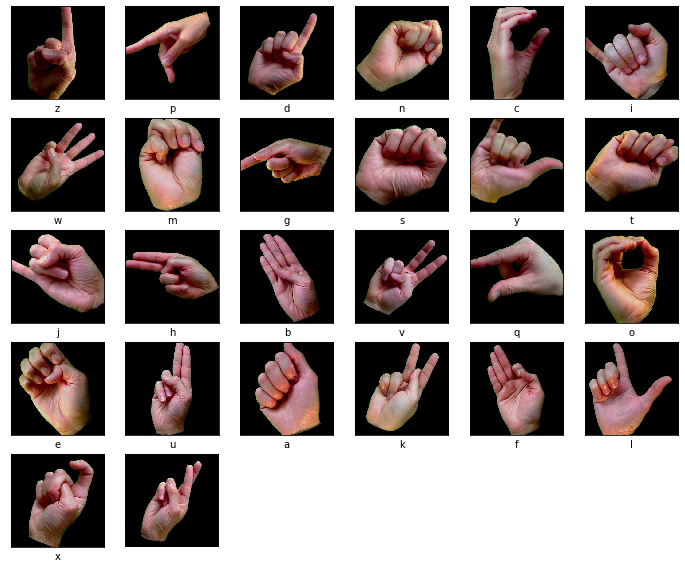

In [4]:
#visualising dataset
fig=plt.figure(figsize=(12,12))
for i in range(len(x_unique)):
    ax=fig.add_subplot(6,6,i+1)
    ax.imshow(x_unique[i])
    plt.xlabel(y_unique[i])
    plt.xticks([])
    plt.yticks([])
plt.axis('off')
plt.show()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Degree range for random rotations
    width_shift_range=0.1,  # Fraction of total width for horizontal shifts
    height_shift_range=0.1,  # Fraction of total height for vertical shifts
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

def create_data(data_path):
    x = []
    y = []
    paths = []
    for label in labels:
        path = os.path.join(data_path, label)
        label_name = labels.index(label)
        for img in os.listdir(path):
            p = os.path.join(path, img)
            paths.append(p)
            try:
                img_array = cv2.imread(p)
                img_array = cv2.resize(img_array, (img_size, img_size))
                
                # Reshape the image to comply with ImageDataGenerator input shape
                img_array = img_array.reshape((1,) + img_array.shape)
                
                # Generate augmented images
                augmented_imgs = []
                for batch in datagen.flow(img_array, batch_size=1):
                    augmented_imgs.append(batch[0].astype('uint8'))
                    if len(augmented_imgs) >= 3:  # Adjust the number of augmented images here
                        break
                
                # Append augmented images to the dataset
                for augmented_img in augmented_imgs:
                    x.append(augmented_img)
                    y.append(label_name)
                
            except Exception as e:
                pass
    return x, y

X, y = create_data(data_path)


In [21]:
NUM_OF_IMAGES = len(X)
print(len(X))

54450


In [22]:
X=np.array(X)

In [23]:
X = X.reshape(NUM_OF_IMAGES, img_size , img_size, num_channels)
print(X.shape)

(54450, 50, 50, 3)


In [24]:
X = X.astype("float32")
X /= 255.0

In [25]:
y = to_categorical(y, num_classes)
print(y.shape)

(54450, 26)


In [26]:
# Perform train-test split
test_size = 0.2  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)


In [27]:
input_shape = (img_size, img_size, 3) 

In [39]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

model_res = Sequential()
model_res.add(base_model)
model_res.add(GlobalAveragePooling2D())
model_res.add(Dropout(0.7)) 
model_res.add(Dense(num_classes, activation='softmax'))


In [40]:
model_res.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model_res.fit(
    X_train,  # Training data
    y_train,  # Training labels
    batch_size=52,
    epochs=5,
    shuffle=True
)

Epoch 1/5
838/838 [==============================] - 1997s 2s/step - loss: 0.8532 - accuracy: 0.7598
Epoch 2/5
838/838 [==============================] - 1982s 2s/step - loss: 0.2358 - accuracy: 0.9325
Epoch 3/5
838/838 [==============================] - 1987s 2s/step - loss: 0.1676 - accuracy: 0.9531
Epoch 4/5
838/838 [==============================] - 2193s 3s/step - loss: 0.1005 - accuracy: 0.9715


In [43]:
model_res.save('resnet_aug3.h5')

In [44]:
test_loss, test_accuracy = model_res.evaluate(X_test, y_test)

341/341 [==============================] - 122s 353ms/step - loss: 0.4320 - accuracy: 0.8994


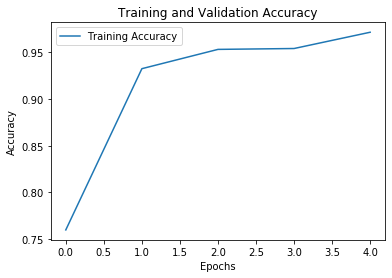

In [47]:
import matplotlib.pyplot as plt
# Plotting training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
import matplotlib.image as mpimg

In [49]:
import json
with open('resnet_model_history.json', 'w') as f:
    json.dump(history.history, f)

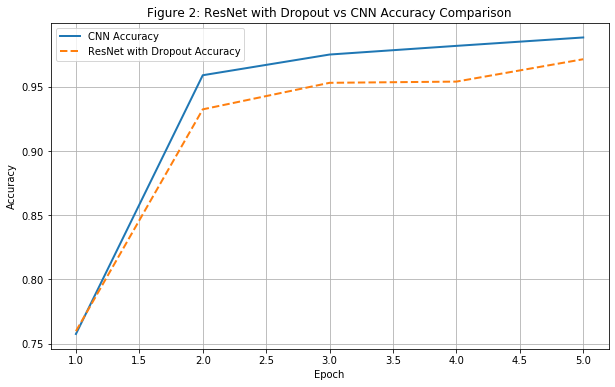

In [52]:
import json
import matplotlib.pyplot as plt

# Load the training history for both models
with open('cnn_model_history.json', 'r') as file:
    cnn_history = json.load(file)

with open('resnet_model_history.json', 'r') as file:
    resnet_history = json.load(file)

# Extracting accuracy values from the histories
cnn_accuracy = cnn_history['accuracy']
resnet_accuracy = resnet_history['accuracy']
epochs = range(1, len(cnn_accuracy) + 1)

# Adjusting the plot with different line styles and labeling
plt.figure(figsize=(10, 6))
plt.plot(epochs, cnn_accuracy, label='CNN Accuracy', linestyle='-', linewidth=2)
plt.plot(epochs, resnet_accuracy, label='ResNet with Dropout Accuracy', linestyle='--', linewidth=2)
plt.title('Figure 2: ResNet with Dropout vs CNN Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [53]:
predictions = model_res.predict(X_test)

341/341 [==============================] - 122s 345ms/step


In [54]:
true_labels = np.argmax(y_test, axis=1)

In [55]:
predicted_labels = np.argmax(predictions, axis=1)

In [57]:
from sklearn.metrics import f1_score

In [58]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [59]:
f1

0.8977074361459247